# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

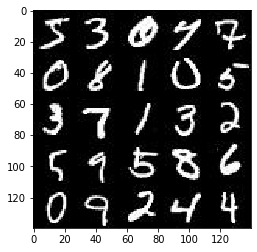

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray');

In [3]:
import numpy as np
print("max   = ", np.max(mnist_images))
print("min   = ", np.min(mnist_images))
print("shape = ", mnist_images.shape) 

max   =  255.0
min   =  0.0
shape =  (25, 28, 28, 1)


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [4]:
# get file paths
file_paths_jpg = glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))
print(file_paths_jpg[:5])

['./data\\img_align_celeba\\000001.jpg', './data\\img_align_celeba\\000002.jpg', './data\\img_align_celeba\\000003.jpg', './data\\img_align_celeba\\000004.jpg', './data\\img_align_celeba\\000005.jpg']


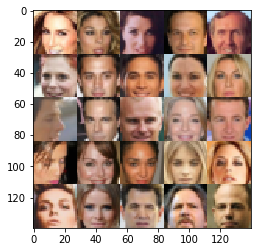

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'));

In [6]:
print("max   = ", np.max(mnist_images))
print("min   = ", np.min(mnist_images))
print("shape = ", mnist_images.shape) 

max   =  255.0
min   =  0.0
shape =  (25, 28, 28, 3)


## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).

## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real   = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_Real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim), name='input_Z')
    learning_rate = tf.placeholder(tf.float32, (None),        name='input_LR')
    #learning_rate = 0.01
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function    
#     with tf.variable_scope("discriminator", reuse=reuse):
#         # Input layer is 28x28x3
#         x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
#         relu1 = tf.maximum(alpha * x1, x1)
#         # 14x14x128
        
#         x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
#         bn2 = tf.layers.batch_normalization(x2, training=True)
#         relu2 = tf.maximum(alpha * bn2, bn2)
#         # 7x7x256
         
#         # Flatten it
#         flat = tf.reshape(relu2, (-1, 7*7*256))
#         logits = tf.layers.dense(flat, 1)
#         out = tf.sigmoid(logits)        
#         return out, logits

    keep_prob = 0.9

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        # Conv-1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha*x1, x1)
        # 14*14*64
        
        # Conv-2
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob) # 収束しないので、追加した
        # 7*7*128
        
        # Conv-3
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob) # 収束しないので、追加した
        # 4*4*256        
        
        # Flatten
        size_list = x3.get_shape().as_list()
        col_flat  = size_list[1] * size_list[2] * size_list[3] # 4*4*256
        flat      = tf.reshape(x3, (-1, col_flat))
        logits    = tf.layers.dense(flat, 1, activation=None)
        out       = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse     = not is_train
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 28x28x128 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same', activation=None)
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)    
    
    
#     with tf.variable_scope('generator', reuse= reuse):
#         # 1st Fully Connected Layer
#         x1 = tf.layers.dense(z, 4*4*512)
        
#         # Reshape it to start the convolutional stack
#         x1 = tf.reshape(x1, (-1,4,4,512))
#         x1 = tf.layers.batch_normalization(x1, training=is_train)
#         x1 = tf.maximum(alpha * x1, x1)
#         # now, 4x4x512
    
#         # Conv-1
#         x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
#         x2 = tf.layers.batch_normalization(x2, training=is_train)
#         x2 = tf.maximum(alpha * x2, x2)
#         # now, 8x8x256
        
#         # Conv-2
#         x3 = tf.layers.conv2d_transpose(x2, 512, 5, strides=2, padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=is_train)
#         x3 = tf.maximum(alpha * x3, x3)
#         # now, 16x16x512        
        
#         # Conv-3, 28x28x out_channel_dim
#         logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 13, strides=1, padding='valid')
#         out    = tf.tanh(logits)
#         # now, 28x28x out_channel_dim
        
#         print("size of generator out = ", out.get_shape())
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Create Models
    # g_model : When is_train is True, reuse is False.
    smooth = 0.1
    g_model                     = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha) 
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True,  alpha=alpha)
    
    # Calculate Loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)* (1 - smooth)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    #
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_var_names = tf.trainable_variables()
    g_var_names = [var for var in t_var_names if var.name.startswith('generator')]
    d_var_names = [var for var in t_var_names if var.name.startswith('discriminator')]
    #
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_var_names)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var_names)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

### Reference Infomation
<ul> 
    <li>model_inputs(image_width, image_height, image_channels, z_dim) <br>
        => inputs_real, inputs_z, learning_rate
    </li>
    <li>model_loss(input_real, input_z, out_channel_dim, alpha=0.2)<br>
        => d_loss, g_loss
    </li>
    <li>model_opt(d_loss, g_loss, learning_rate, beta1)<br>
        => d_train_opt, g_train_opt
    </li>
</ul>

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #-----------------------------------------------------#
    # TODO: Build Model

    # 入力用の変数の作成
    image_width    = data_shape[1]
    image_height   = data_shape[2]
    image_channels = data_shape[3]
    
    # modelの作成
    inputs_real, inputs_z, inputs_lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # lossの計算
    out_channel_dim = image_channels
    d_loss, g_loss  = model_loss(inputs_real, inputs_z, out_channel_dim, alpha=0.2)
    
    # 最適化器の作成
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, inputs_lr, beta1)
    #-----------------------------------------------------#    
    saver       = tf.train.Saver()
    print_every = 20
    steps       = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # sample random noise for G
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1.0, 1.0, size=(batch_size, z_dim)).astype(np.float32)

                # run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real:batch_images, inputs_z:batch_z, inputs_lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real:batch_images, inputs_z:batch_z, inputs_lr:learning_rate})
                
                # show results
                if steps % 20 == 0:
                    train_loss_d = d_loss.eval({inputs_real:batch_images, inputs_z:batch_z})
                    train_loss_g = g_loss.eval({inputs_real:batch_images, inputs_z:batch_z})

                    print("Epoch {}/{}... steps:{} ".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
          
        #---------------------------------------
        print("final Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
        show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)                    
                    
                    
        #
        saver.save(sess, './chackpoints/generator.ckpt')
                    
                    

In [15]:
# helper.Dataset scales the data range to -0.5 ~ 0.5.

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... steps:20  Discriminator Loss: 0.0996... Generator Loss: 2.6485
Epoch 1/2... steps:40  Discriminator Loss: 0.0056... Generator Loss: 5.1460
Epoch 1/2... steps:60  Discriminator Loss: 0.0110... Generator Loss: 4.8890
Epoch 1/2... steps:80  Discriminator Loss: 0.0018... Generator Loss: 10.8461
Epoch 1/2... steps:100  Discriminator Loss: 0.0041... Generator Loss: 6.1794


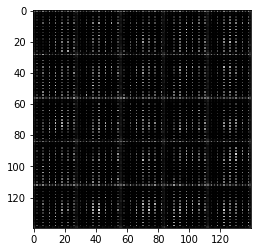

Epoch 1/2... steps:120  Discriminator Loss: 0.3071... Generator Loss: 1.3185
Epoch 1/2... steps:140  Discriminator Loss: 0.0042... Generator Loss: 5.4670
Epoch 1/2... steps:160  Discriminator Loss: 1.0619... Generator Loss: 1.0089
Epoch 1/2... steps:180  Discriminator Loss: 1.5196... Generator Loss: 0.8240
Epoch 1/2... steps:200  Discriminator Loss: 0.9648... Generator Loss: 1.7318


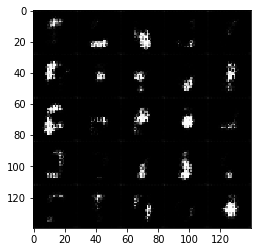

Epoch 1/2... steps:220  Discriminator Loss: 0.7994... Generator Loss: 1.0587
Epoch 1/2... steps:240  Discriminator Loss: 1.2296... Generator Loss: 1.7170
Epoch 1/2... steps:260  Discriminator Loss: 0.8293... Generator Loss: 1.5744
Epoch 1/2... steps:280  Discriminator Loss: 0.7962... Generator Loss: 1.6533
Epoch 1/2... steps:300  Discriminator Loss: 0.9286... Generator Loss: 1.1869


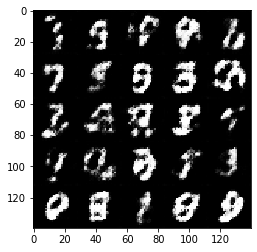

Epoch 1/2... steps:320  Discriminator Loss: 1.0822... Generator Loss: 1.4927
Epoch 1/2... steps:340  Discriminator Loss: 0.9619... Generator Loss: 1.1829
Epoch 1/2... steps:360  Discriminator Loss: 0.8759... Generator Loss: 1.1375
Epoch 1/2... steps:380  Discriminator Loss: 0.8688... Generator Loss: 1.0185
Epoch 1/2... steps:400  Discriminator Loss: 1.1319... Generator Loss: 0.6954


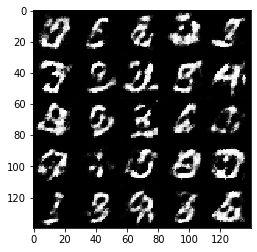

Epoch 1/2... steps:420  Discriminator Loss: 1.2963... Generator Loss: 0.5234
Epoch 1/2... steps:440  Discriminator Loss: 0.7572... Generator Loss: 1.1763
Epoch 1/2... steps:460  Discriminator Loss: 0.7212... Generator Loss: 0.9575
Epoch 2/2... steps:480  Discriminator Loss: 0.7640... Generator Loss: 1.6978
Epoch 2/2... steps:500  Discriminator Loss: 0.8715... Generator Loss: 1.0289


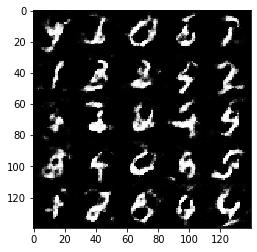

Epoch 2/2... steps:520  Discriminator Loss: 0.8078... Generator Loss: 1.0357
Epoch 2/2... steps:540  Discriminator Loss: 0.9765... Generator Loss: 0.9077
Epoch 2/2... steps:560  Discriminator Loss: 0.8614... Generator Loss: 1.3416
Epoch 2/2... steps:580  Discriminator Loss: 0.9537... Generator Loss: 1.6624
Epoch 2/2... steps:600  Discriminator Loss: 0.9157... Generator Loss: 0.8986


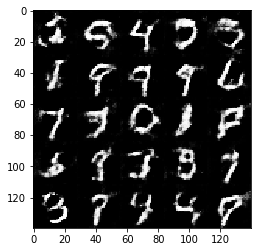

Epoch 2/2... steps:620  Discriminator Loss: 0.9314... Generator Loss: 1.0765
Epoch 2/2... steps:640  Discriminator Loss: 1.4360... Generator Loss: 0.5445
Epoch 2/2... steps:660  Discriminator Loss: 1.0511... Generator Loss: 0.8591
Epoch 2/2... steps:680  Discriminator Loss: 0.9294... Generator Loss: 1.1763
Epoch 2/2... steps:700  Discriminator Loss: 0.9592... Generator Loss: 0.8711


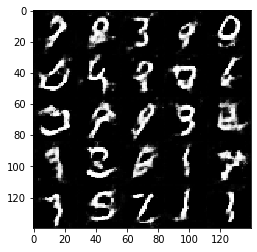

Epoch 2/2... steps:720  Discriminator Loss: 0.9239... Generator Loss: 1.1083
Epoch 2/2... steps:740  Discriminator Loss: 0.8730... Generator Loss: 0.9660
Epoch 2/2... steps:760  Discriminator Loss: 0.9095... Generator Loss: 0.9934
Epoch 2/2... steps:780  Discriminator Loss: 1.1680... Generator Loss: 1.6208
Epoch 2/2... steps:800  Discriminator Loss: 1.0226... Generator Loss: 1.2339


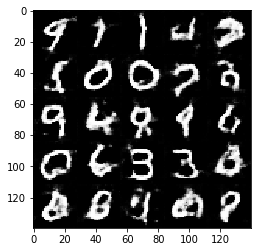

Epoch 2/2... steps:820  Discriminator Loss: 0.9174... Generator Loss: 1.2979
Epoch 2/2... steps:840  Discriminator Loss: 0.8896... Generator Loss: 0.9732
Epoch 2/2... steps:860  Discriminator Loss: 0.9594... Generator Loss: 0.8820
Epoch 2/2... steps:880  Discriminator Loss: 0.8824... Generator Loss: 1.2935
Epoch 2/2... steps:900  Discriminator Loss: 0.9157... Generator Loss: 1.0320


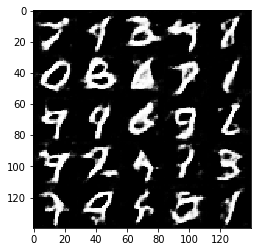

Epoch 2/2... steps:920  Discriminator Loss: 0.9758... Generator Loss: 1.0329
final Discriminator Loss: 0.9758... Generator Loss: 1.0329


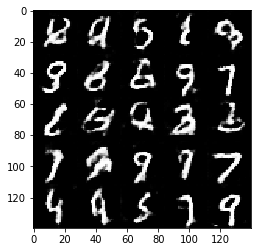

In [16]:
batch_size    = 128
z_dim         = 100
learning_rate = 0.0002
beta1         = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... steps:20  Discriminator Loss: 0.4730... Generator Loss: 2.6329
Epoch 1/1... steps:40  Discriminator Loss: 0.5805... Generator Loss: 8.0612
Epoch 1/1... steps:60  Discriminator Loss: 0.3131... Generator Loss: 3.6074
Epoch 1/1... steps:80  Discriminator Loss: 0.9830... Generator Loss: 0.7302
Epoch 1/1... steps:100  Discriminator Loss: 1.5601... Generator Loss: 0.5710


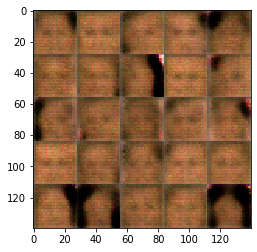

Epoch 1/1... steps:120  Discriminator Loss: 1.2179... Generator Loss: 0.8674
Epoch 1/1... steps:140  Discriminator Loss: 1.0466... Generator Loss: 0.8642
Epoch 1/1... steps:160  Discriminator Loss: 1.1053... Generator Loss: 0.8210
Epoch 1/1... steps:180  Discriminator Loss: 1.2466... Generator Loss: 0.8346
Epoch 1/1... steps:200  Discriminator Loss: 1.0707... Generator Loss: 0.5920


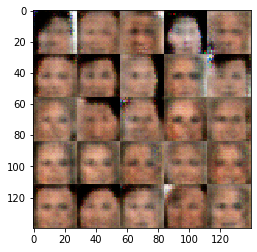

Epoch 1/1... steps:220  Discriminator Loss: 1.3795... Generator Loss: 0.5408
Epoch 1/1... steps:240  Discriminator Loss: 1.1188... Generator Loss: 1.0327
Epoch 1/1... steps:260  Discriminator Loss: 1.0680... Generator Loss: 1.3291
Epoch 1/1... steps:280  Discriminator Loss: 1.1151... Generator Loss: 0.9405
Epoch 1/1... steps:300  Discriminator Loss: 1.1261... Generator Loss: 0.8013


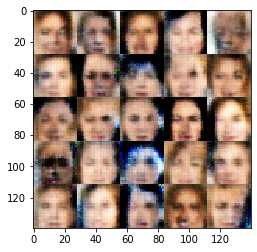

Epoch 1/1... steps:320  Discriminator Loss: 1.2073... Generator Loss: 0.5461
Epoch 1/1... steps:340  Discriminator Loss: 1.1833... Generator Loss: 1.0777
Epoch 1/1... steps:360  Discriminator Loss: 1.4195... Generator Loss: 1.4689
Epoch 1/1... steps:380  Discriminator Loss: 1.5177... Generator Loss: 1.5453
Epoch 1/1... steps:400  Discriminator Loss: 1.2015... Generator Loss: 0.7323


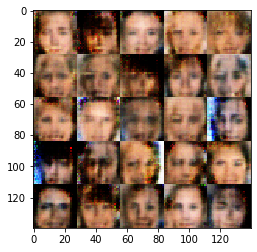

Epoch 1/1... steps:420  Discriminator Loss: 1.1314... Generator Loss: 1.3306
Epoch 1/1... steps:440  Discriminator Loss: 1.1412... Generator Loss: 0.7423
Epoch 1/1... steps:460  Discriminator Loss: 1.2673... Generator Loss: 0.6933
Epoch 1/1... steps:480  Discriminator Loss: 1.3764... Generator Loss: 0.7607
Epoch 1/1... steps:500  Discriminator Loss: 1.2295... Generator Loss: 0.6513


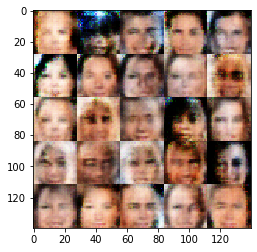

Epoch 1/1... steps:520  Discriminator Loss: 1.2717... Generator Loss: 0.6106
Epoch 1/1... steps:540  Discriminator Loss: 1.1069... Generator Loss: 0.7371
Epoch 1/1... steps:560  Discriminator Loss: 1.2249... Generator Loss: 0.7734
Epoch 1/1... steps:580  Discriminator Loss: 1.5956... Generator Loss: 1.6423
Epoch 1/1... steps:600  Discriminator Loss: 1.3705... Generator Loss: 0.6566


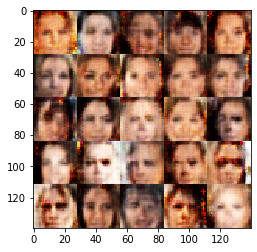

Epoch 1/1... steps:620  Discriminator Loss: 1.2707... Generator Loss: 1.0468
Epoch 1/1... steps:640  Discriminator Loss: 1.2064... Generator Loss: 0.7623
Epoch 1/1... steps:660  Discriminator Loss: 1.4122... Generator Loss: 1.0322
Epoch 1/1... steps:680  Discriminator Loss: 1.9524... Generator Loss: 1.9655
Epoch 1/1... steps:700  Discriminator Loss: 1.2830... Generator Loss: 0.8084


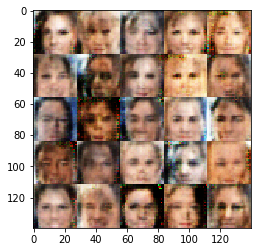

Epoch 1/1... steps:720  Discriminator Loss: 1.3405... Generator Loss: 1.2397
Epoch 1/1... steps:740  Discriminator Loss: 1.2465... Generator Loss: 0.7097
Epoch 1/1... steps:760  Discriminator Loss: 2.2485... Generator Loss: 2.1964
Epoch 1/1... steps:780  Discriminator Loss: 1.3751... Generator Loss: 0.8537
Epoch 1/1... steps:800  Discriminator Loss: 1.1912... Generator Loss: 0.6271


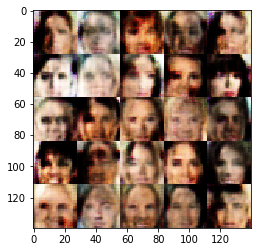

Epoch 1/1... steps:820  Discriminator Loss: 1.2417... Generator Loss: 0.6121
Epoch 1/1... steps:840  Discriminator Loss: 1.2600... Generator Loss: 0.7217
Epoch 1/1... steps:860  Discriminator Loss: 1.2640... Generator Loss: 0.8362
Epoch 1/1... steps:880  Discriminator Loss: 1.5110... Generator Loss: 0.8221
Epoch 1/1... steps:900  Discriminator Loss: 1.5354... Generator Loss: 0.5920


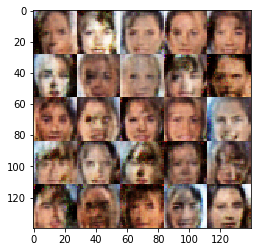

Epoch 1/1... steps:920  Discriminator Loss: 1.2288... Generator Loss: 0.7415
Epoch 1/1... steps:940  Discriminator Loss: 1.7096... Generator Loss: 0.4256
Epoch 1/1... steps:960  Discriminator Loss: 1.6174... Generator Loss: 1.1826
Epoch 1/1... steps:980  Discriminator Loss: 1.2235... Generator Loss: 0.8593
Epoch 1/1... steps:1000  Discriminator Loss: 1.2870... Generator Loss: 0.8559


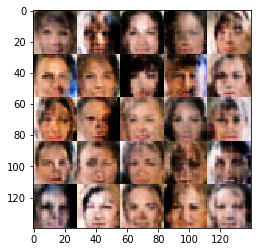

Epoch 1/1... steps:1020  Discriminator Loss: 1.9042... Generator Loss: 1.3586
Epoch 1/1... steps:1040  Discriminator Loss: 1.2700... Generator Loss: 0.6076
Epoch 1/1... steps:1060  Discriminator Loss: 1.1897... Generator Loss: 1.0030
Epoch 1/1... steps:1080  Discriminator Loss: 1.3954... Generator Loss: 0.8390
Epoch 1/1... steps:1100  Discriminator Loss: 1.4122... Generator Loss: 0.5626


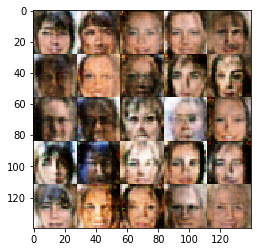

Epoch 1/1... steps:1120  Discriminator Loss: 1.4058... Generator Loss: 0.6626
Epoch 1/1... steps:1140  Discriminator Loss: 1.3442... Generator Loss: 0.7695
Epoch 1/1... steps:1160  Discriminator Loss: 1.4263... Generator Loss: 0.6312
Epoch 1/1... steps:1180  Discriminator Loss: 1.3805... Generator Loss: 0.8303
Epoch 1/1... steps:1200  Discriminator Loss: 1.3099... Generator Loss: 0.8044


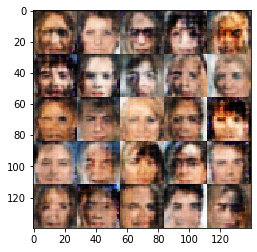

Epoch 1/1... steps:1220  Discriminator Loss: 1.3682... Generator Loss: 0.8946
Epoch 1/1... steps:1240  Discriminator Loss: 1.4483... Generator Loss: 0.4770
Epoch 1/1... steps:1260  Discriminator Loss: 1.2959... Generator Loss: 0.7313
Epoch 1/1... steps:1280  Discriminator Loss: 1.5118... Generator Loss: 0.6845
Epoch 1/1... steps:1300  Discriminator Loss: 1.4822... Generator Loss: 0.5177


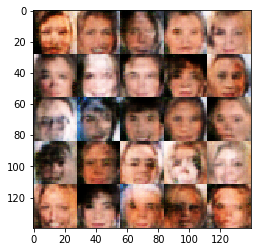

Epoch 1/1... steps:1320  Discriminator Loss: 1.4333... Generator Loss: 0.6410
Epoch 1/1... steps:1340  Discriminator Loss: 1.3106... Generator Loss: 0.7111
Epoch 1/1... steps:1360  Discriminator Loss: 1.2322... Generator Loss: 0.7134
Epoch 1/1... steps:1380  Discriminator Loss: 1.2909... Generator Loss: 0.7412
Epoch 1/1... steps:1400  Discriminator Loss: 1.3480... Generator Loss: 0.7648


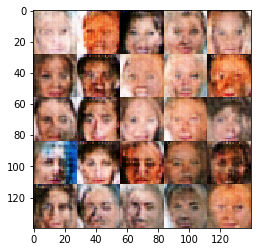

Epoch 1/1... steps:1420  Discriminator Loss: 1.4345... Generator Loss: 0.7962
Epoch 1/1... steps:1440  Discriminator Loss: 1.4741... Generator Loss: 1.0596
Epoch 1/1... steps:1460  Discriminator Loss: 1.2023... Generator Loss: 0.7950
Epoch 1/1... steps:1480  Discriminator Loss: 1.3537... Generator Loss: 0.8285
Epoch 1/1... steps:1500  Discriminator Loss: 1.3095... Generator Loss: 0.6945


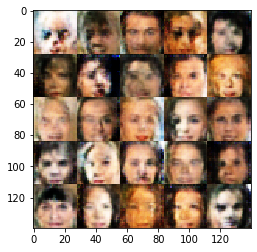

Epoch 1/1... steps:1520  Discriminator Loss: 1.3063... Generator Loss: 0.7350
Epoch 1/1... steps:1540  Discriminator Loss: 1.4382... Generator Loss: 0.9413
Epoch 1/1... steps:1560  Discriminator Loss: 1.2644... Generator Loss: 0.8487
Epoch 1/1... steps:1580  Discriminator Loss: 1.2623... Generator Loss: 0.7569
final Discriminator Loss: 1.2623... Generator Loss: 0.7569


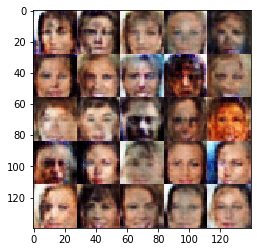

In [ ]:
batch_size    = 128
z_dim         = 100
learning_rate = 0.0008
beta1         = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.